In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup

In [89]:
# optical setup size
lx = 15
ly = 15

# number of nodes
Nx = 1500
Ny = 1500
# wavelength
lam = 1064 * 1e-6

# focal distance of the lens
focal = 150
# radius of the lens
r = 20
# distance between the screen od the lens
distance = focal

# waist radius of the gaussian beam
w0 = 1.

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


dx = lx / Nx
dy = ly / Ny

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


In [90]:
period =  1.5 * lam

grating_transmission_function = torch.sin(torch.tensor(xv) / period)


In [91]:
field_before_grating = Wavefront.gaussian_beam(
    simulation_parameters=params,
    distance=2 * distance,
    waist_radius=w0
)

intensity_source = field_before_grating.intensity.detach().numpy()


field_after_grating = field_before_grating * grating_transmission_function

free_space1 = elements.FreeSpace(
    simulation_parameters=params,
    distance=torch.tensor(focal),
    method='AS'
)

field_before_first_lens = free_space1.forward(input_field=field_after_grating)

first_lens = elements.ThinLens(
    simulation_parameters=params,
    focal_length=focal, radius=r
)

field_after_first_lens = first_lens.forward(input_field=field_before_first_lens)

free_space2 = elements.FreeSpace(
    simulation_parameters=params,
    distance=2 * torch.tensor(focal),
    method='AS'
)

field_before_second_lens = free_space2.forward(
    input_field=field_after_first_lens
)

second_lens = elements.ThinLens(
    simulation_parameters=params,
    focal_length=focal, radius=r
)

field_after_second_lens = second_lens.forward(
    input_field=field_before_second_lens
)

free_space3 = elements.FreeSpace(
    simulation_parameters=params,
    distance=torch.tensor(focal),
    method='AS'
)

output_field = free_space3.forward(input_field=field_after_second_lens)

intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()



optical_setup = LinearOpticalSetup(
    [free_space1, first_lens, free_space2, second_lens, free_space3]
)

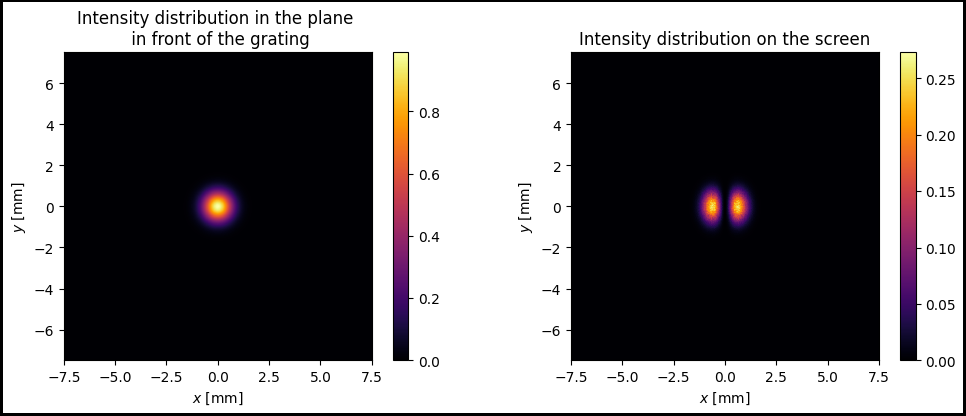

In [92]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    edgecolor='black',
    linewidth=3,
    frameon=True
)

im1 = ax[0].pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Intensity distribution in the plane \n in front of the grating')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Intensity distribution on the screen')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

In [93]:
result_hio = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    target_phase=None,
    target_region=None,
    initial_phase=None,
    method='HIO',
    options= {
        'tol': 1e-20,
        'maxiter': 50,
        'constant_factor': float == 0.5,
        'disp': False
    }
)

result_gs = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    target_phase=None,
    target_region=None,
    initial_phase=None,
    method='GS',
    options= {
        'tol': 1e-20,
        'maxiter': 50,
        'disp': False
    }
)

phase_distribution_hio = result_hio.solution
phase_distribution_gs = result_gs.solution


niter_hio = result_hio.number_of_iterations
niter_gs = result_gs.number_of_iterations

error_mass_hio = result_hio.cost_func_evolution
error_mass_gs = result_gs.cost_func_evolution

In [94]:

step = 2 * torch.pi / 256
mask = phase_distribution_hio // step

n_hio = np.arange(1, niter_hio+1)
n_gs = np.arange(1, niter_gs+1)

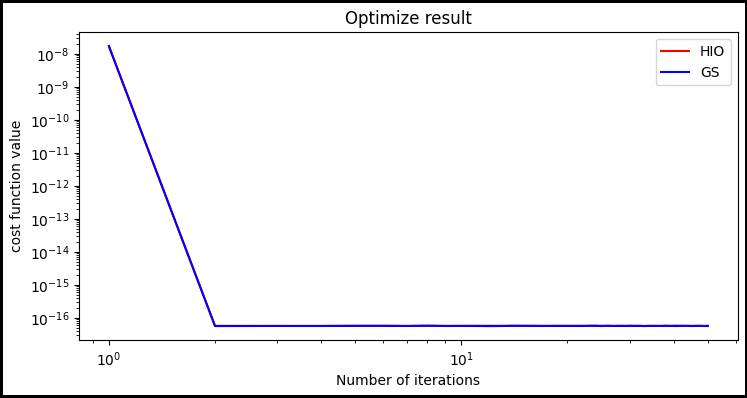

In [95]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title(r'Optimize result')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('cost function value')

ax.loglog(n_hio, error_mass_hio, label='HIO', color='red')
ax.loglog(n_gs, error_mass_gs, label='GS', color='blue')

ax.legend()


In [96]:
field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_grating)

output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

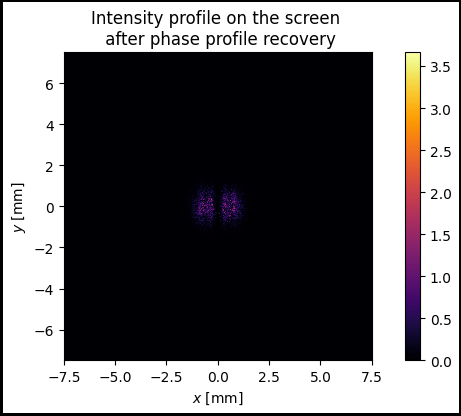

In [97]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen \n after phase profile recovery')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [98]:
E1 = np.sum(intensity_target_opt) * dx * dy
E2 = np.sum(intensity_target) * dx * dy
print(E1)
print(E2)

print(np.std(intensity_target_opt - intensity_target))

1.5687017132067396
0.46479789583277337
0.04940028727427617
